# Logistic regression models

This notebook trains logistic regression models to identify NYC roads that are within the top 1%, 5% and 10% of the roads with highest collision rates.

In [64]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [65]:
from pathlib import Path

DATA_FOLDER = Path("../data")

In [66]:
import pandas as pd

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")
collisions_df = collisions.drop(columns=["physicalid", "geometry"])

In [67]:
collisions_df["is_top_1"] = collisions_df["percentile"] == "top_1"
collisions_df["is_top_5"] = collisions_df["percentile"] >= "top_5"
collisions_df["is_top_10"] = collisions_df["percentile"] >= "top_10"

In [68]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42, stratify=collisions["percentile"]
)

In [69]:
import numpy as np
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

collisions_train["log_leng"] = np.log(collisions_train["shape_leng"])
collisions_train["log_width"] = np.log(collisions_train["st_width"])
collisions_train["inv_trees"] = 1.0 / (1 + collisions_train["n_trees"])

In [70]:
regression_features = [
    "log_width",
    "log_leng",
    "inv_trees",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
]

In [71]:
X_train = collisions_train[regression_features]
y_train_1 = collisions_train["is_top_1"].copy()
y_train_5 = collisions_train["is_top_5"].copy()
y_train_10 = collisions_train["is_top_10"].copy()

In [117]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train, y_train_1, stratify=y_train_1, test_size=0.1, random_state=42
)
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_train, y_train_5, stratify=y_train_5, test_size=0.1, random_state=42
)
X_train_10, X_val_10, y_train_10, y_val_10 = train_test_split(
    X_train, y_train_10, stratify=y_train_10, test_size=0.1, random_state=42
)

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns = X_train.columns
X_train_norm_1 = scaler.fit_transform(X_train_1)
X_train_norm_5 = scaler.fit_transform(X_train_5)
X_train_norm_10 = scaler.fit_transform(X_train_10)

X_val_norm_1 = scaler.fit_transform(X_val_1)
X_val_norm_5 = scaler.fit_transform(X_val_5)
X_val_norm_10 = scaler.fit_transform(X_val_10)


X_train_norm_1 = pd.DataFrame(X_train_norm_1, columns=columns)
X_train_norm_5 = pd.DataFrame(X_train_norm_5, columns=columns)
X_train_norm_10 = pd.DataFrame(X_train_norm_10, columns=columns)

X_val_norm_1 = pd.DataFrame(X_val_norm_1, columns=columns)
X_val_norm_5 = pd.DataFrame(X_val_norm_5, columns=columns)
X_val_norm_10 = pd.DataFrame(X_val_norm_10, columns=columns)

In [119]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

X_over_1, y_over_1 = over_sampler.fit_resample(X_train_norm_1, y_train_1)
X_over_5, y_over_5 = over_sampler.fit_resample(X_train_norm_5, y_train_5)
X_over_10, y_over_10 = over_sampler.fit_resample(X_train_norm_10, y_train_10)

In [120]:
from sklearn.linear_model import LogisticRegression

base_log_reg = LogisticRegression(penalty=None)

In [121]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)

base_log_reg.fit(X_over_1, y_over_1)

LogisticRegression(penalty=None)

In [122]:
y_pred = base_log_reg.predict(X_val_norm_1)
precision_1, recall_1, f1_1, auc_1 = (
    precision_score(y_val_1, y_pred),
    recall_score(y_val_1, y_pred),
    f1_score(y_val_1, y_pred),
    roc_auc_score(y_val_1, y_pred),
)

In [123]:
precision_1, recall_1, f1_1, auc_1

(0.04141104294478527,
 0.8059701492537313,
 0.0787746170678337,
 0.8100344499986684)

In [124]:
y_pred_proba = base_log_reg.predict_proba(X_val_1)
prec_1, rec_1, thres = precision_recall_curve(y_val_1, y_pred_proba[:, 1])

Text(0.5, 0, 'Threshold')

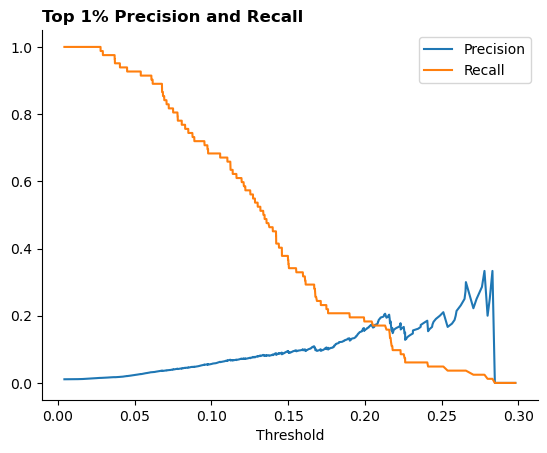

In [80]:
plt.plot(thres, prec_1[:-1], label="Precision")
plt.plot(thres, rec_1[:-1], label="Recall")
plt.legend()
plt.title("Top 1% Precision and Recall")
plt.xlabel("Threshold")

In [125]:
base_log_reg.fit(X_over_5, y_over_5)

LogisticRegression(penalty=None)

In [134]:
def plot_precision_recall_curve(model, X_train, y_train, X_val, y_val, percentile):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba[:, 1])
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.legend()
    plt.title(f"Top {percentile}% Precision and Recall")
    plt.xlabel("Threshold")

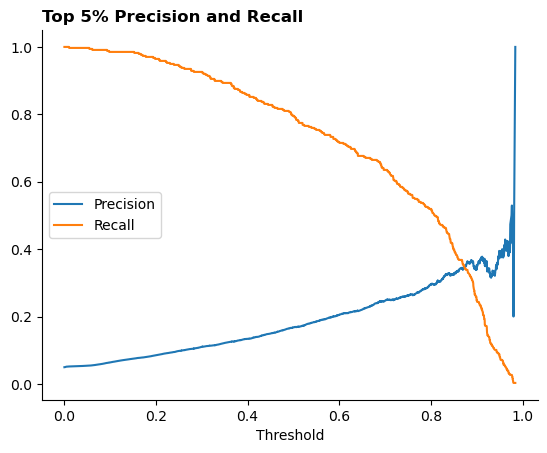

In [135]:
plot_precision_recall_curve(base_log_reg, X_over_5, y_over_5, X_val_norm_5, y_val_5, 5)

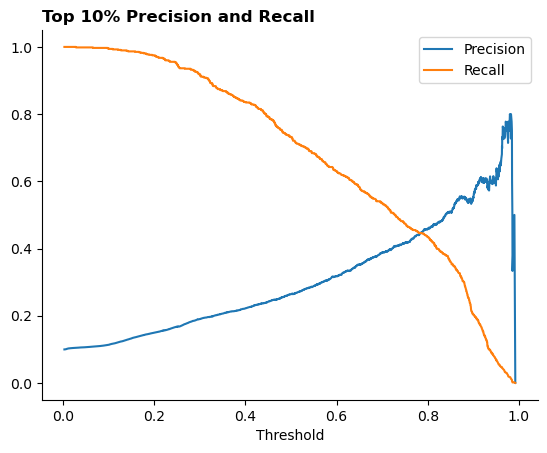

In [136]:
plot_precision_recall_curve(
    base_log_reg, X_over_10, y_over_10, X_val_norm_10, y_val_10, 10
)

### Lasso regression

In [129]:
from sklearn.metrics import log_loss, precision_score, recall_score

lasso_reg = LogisticRegression(max_iter=10000, penalty="l1")


def get_scores_for_lasso(
    X_train, y_train, X_train_not_over, y_train_not_over, X_val, y_val
):
    cs = np.linspace(0.001, 1, 100)

    data_array = np.zeros(shape=(100, len(regression_features) + 7))

    for i, c in enumerate(cs):
        log_reg = LogisticRegression(
            max_iter=10000, penalty="l1", C=c, solver="saga", n_jobs=-1
        )
        log_reg.fit(X_train, y_train)
        y_pred_val = log_reg.predict(X_val)
        y_pred_proba_val = log_reg.predict_proba(X_val)
        y_pred_train = log_reg.predict(X_train_not_over)
        y_pred_proba_train = log_reg.predict_proba(X_train_not_over)
        val_loss = log_loss(y_val, y_pred_proba_val)
        train_loss = log_loss(y_train_not_over, y_pred_proba_train)
        data_array[i, 0] = c
        data_array[i, -6] = train_loss
        data_array[i, -5] = val_loss
        train_precision = precision_score(y_train_not_over, y_pred_train)
        val_precision = precision_score(y_val, y_pred_val)
        train_recall = recall_score(y_train_not_over, y_pred_train)
        val_recall = recall_score(y_val, y_pred_val)
        data_array[i, -4] = train_recall
        data_array[i, -3] = val_recall
        data_array[i, -2] = train_precision
        data_array[i, -1] = val_precision
        data_array[i, 1:-6] = log_reg.coef_
    columns = (
        ["C"]
        + list(log_reg.feature_names_in_)
        + [
            "train_loss",
            "val_loss",
            "train_recall",
            "val_recall",
            "train_precision",
            "val_precision",
        ]
    )
    return pd.DataFrame(data_array, columns=columns)

In [130]:
scores_1 = get_scores_for_lasso(
    X_over_1, y_over_1, X_train_norm_1, y_train_1, X_val_norm_1, y_val_1
)
scores_5 = get_scores_for_lasso(
    X_over_5, y_over_5, X_train_norm_5, y_train_5, X_val_norm_5, y_val_5
)
scores_10 = get_scores_for_lasso(
    X_over_10, y_over_10, X_train_norm_10, y_train_10, X_val_norm_10, y_val_10
)

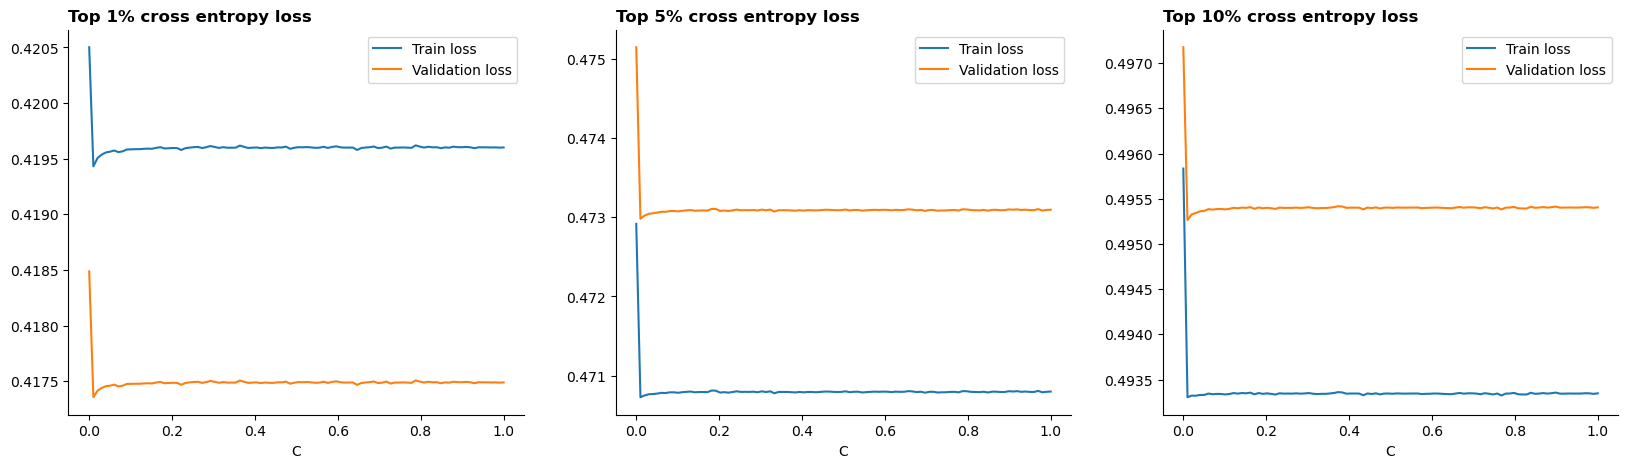

In [131]:
scores = [scores_1, scores_5, scores_10]
percs = [1, 5, 10]

_, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, s in enumerate(scores):
    ax[i].plot(s.C.values, s.train_loss.values, label="Train loss")
    ax[i].plot(s.C.values, s.val_loss.values, label="Validation loss")
    ax[i].legend()
    ax[i].set_xlabel("C")
    ax[i].set_title(f"Top {percs[i]}% cross entropy loss")

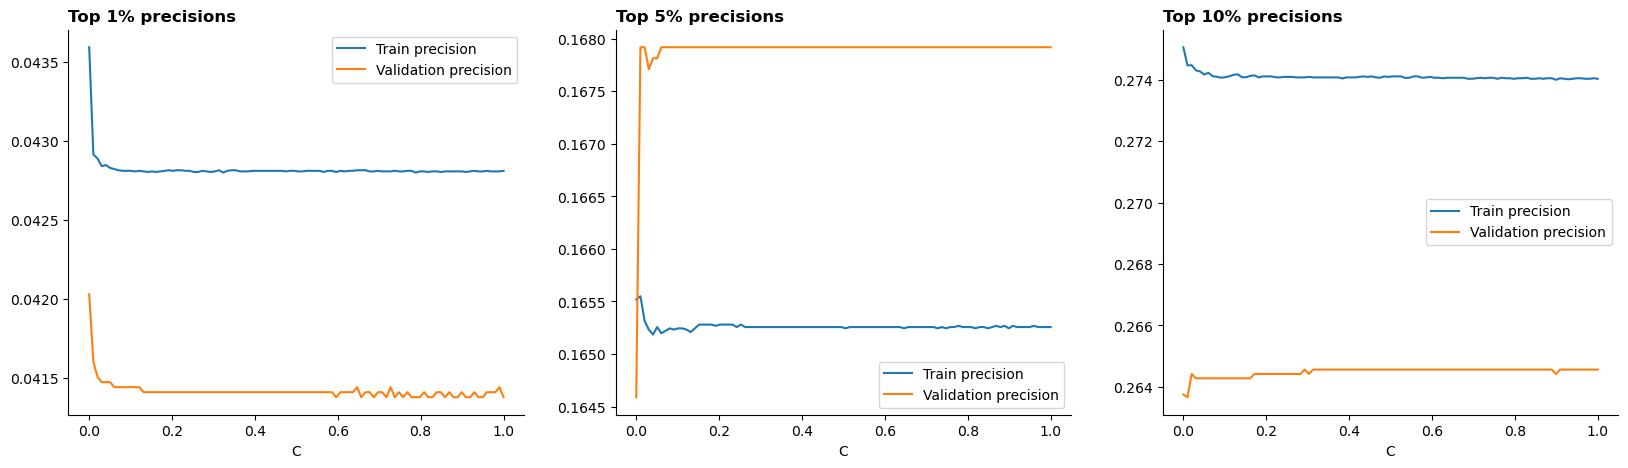

In [132]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, s in enumerate(scores):
    ax[i].plot(s.C.values, s.train_precision.values, label="Train precision")
    ax[i].plot(s.C.values, s.val_precision.values, label="Validation precision")
    ax[i].legend()
    ax[i].set_xlabel("C")
    ax[i].set_title(f"Top {percs[i]}% precisions")

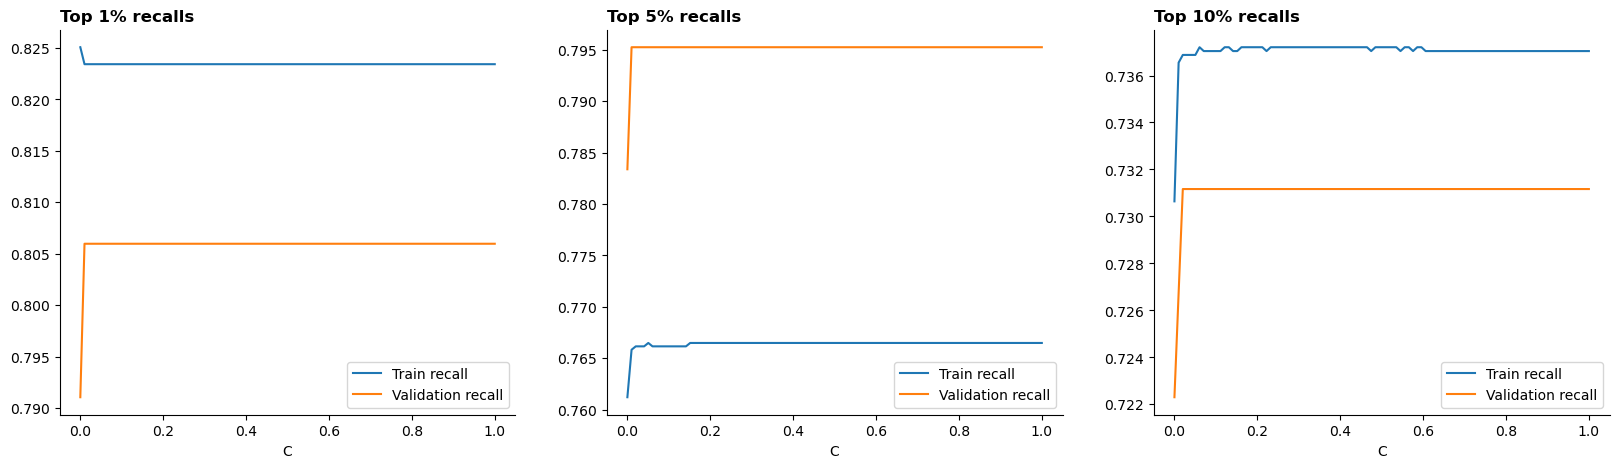

In [133]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, s in enumerate(scores):
    ax[i].plot(s.C.values, s.train_recall.values, label="Train recall")
    ax[i].plot(s.C.values, s.val_recall.values, label="Validation recall")
    ax[i].legend()
    ax[i].set_xlabel("C")
    ax[i].set_title(f"Top {percs[i]}% recalls")